In [20]:
%load_ext autoreload
%autoreload 2

import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
import numpy as np

from src.modules import plotter as p
from src.modules.analysis import analyseValue, createScenarios, runScen
from src.modules.probabilities import Probabilities
from src.modules import plotter as plttr

plt.style.use(['seaborn-paper','science','no-latex', 'std-colors'])
matplotlib.rc("font", family="Times New Roman")    
plts = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Config
param = {"T": 3, "trip_max": 3, "iterations_avi": 1, "iterations_adp": 100, "samples_avi": 1000, "samples_adp": None}
states = '[%s-%s]-statespace' % (param["T"], param["trip_max"])
algos = ['mo', "adp"]
iniState = '0,4.0,0.0,0.0,0.044,0.039'
prob = Probabilities()
runs = [("Value Iteration", "vi/20210614_1018"), ("Myopic Optimization", "mo/20210620_1306"), 
       ("Approx. Value Iteration", "avi/20210614_1011"), ("Approx. Dynamic Programming", "adp/20210620_1309")]

In [27]:
# Load decisions
dict_dec = {}

decisions = ["[vi]-[%s-%s]" % (param["T"], param["trip_max"]), 
             "[mo]-[%s-%s]" % (param["T"], param["trip_max"]), 
             "[avi-(%s %s)]-[%s-%s]" % (param["iterations_avi"], param["samples_avi"], param["T"], param["trip_max"]),
             "[adp-(%s None)]-[%s-%s]" % (param["iterations_adp"], param["T"], param["trip_max"])]

dict_dec["mo"] = pd.read_pickle("/usr/app/output/xlsx/%s/%s-best_decisions.pkl" % (runs[1][1], decisions[1]))
#dict_dec["avi"] = pd.read_pickle("/usr/app/output/xlsx/%s/%s-best_decisions.pkl" % (runs[2][1],decisions[2]))
dict_dec["adp"] = pd.read_pickle("/usr/app/output/xlsx/%s/%s-best_decisions.pkl" % (runs[3][1],decisions[3]))

# Load states
df_states = pd.read_pickle("/usr/app/output/df/%s.pkl" % states)

analyseValue(dict_dec, iniState, prob, df_states["s_obj"].to_dict(), param)

,Algorithm,Scenario,Value
0,mo,0,-299.969200
1,mo,1,0.011000
2,mo,2,0.008386
3,adp,0,-249.975900
4,adp,1,0.009500
5,adp,2,0.007329


In [ ]:
# [GEN] => see data analysis
## 1. Electricity prices for buy and sell with error bars at time
d_prc_b = pd.read_pickle("/usr/app/data/probabilities/d_prc_b.pkl") 
d_prc_s = pd.read_pickle("/usr/app/data/probabilities/d_prc_s.pkl") 
d_prc_b["type"] = "b"
d_prc_s["type"] = "s"
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=pd.concat([d_prc_b, d_prc_s]), x="t", y="prc", hue="type", legend = False)
plttr.formatPlot(g, "Time (min)" , "Price (€/kWh)","Buying and Selling Prices with Error Bounds" , np.arange(0, 1441, 60), None, "Price Type", ['Buying', 'Selling'], "upper left")
plts = [("prob_prc_t", plt.gcf())]


In [ ]:
## 2. Probability to start trip at time
d_trpstrt = pd.read_pickle("/usr/app/data/probabilities/trpstrt.pkl") 
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.barplot(ax=ax, data=d_trpstrt, x="t", y="p(t)", color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plttr.formatPlot(g, "Time (min)" ,"Probability","Tripstart Probability", dense=4)

plts += [("prob_trpstrt", plt.gcf())]


In [ ]:
## 3. Probability for trip length according to length and time
d_trpln = pd.read_pickle("/usr/app/data/probabilities/trplen.pkl") 
d_trpln = pd.melt(d_trpln.iloc[:,:-1].copy(), id_vars=['t'], var_name = "Length", value_name = "d(t)")
d_trpln["d(t)"] = d_trpln["d(t)"]*100
d_trpln["d(t)"] = d_trpln["d(t)"].astype("int32")
d_trpln_pivot = d_trpln.pivot("t", "Length", "d(t)")


In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(x=d_trpln["Length"], y=d_trpln["d(t)"]/100,legend = False)
plttr.formatPlot(g, "Triplength", "Probability", "Avg. Probability of Triplengths with Error Bounds")
plts += [("prob_trpln_agg", plt.gcf())]

In [ ]:
g = sns.FacetGrid(d_trpln, col="t", col_wrap = 6)
g.map_dataframe(sns.barplot, x="Length", y="d(t)")
plttr.formatPlot(g, "Distance", "Probability", "Probability of Triplengths", dense=4)

plts += [("prob_trpln_indiv", plt.gcf())]

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(d_trpln_pivot, annot=True, fmt="d", linewidths=.5, ax=ax, cmap = sns.color_palette("viridis", as_cmap=True))
plttr.formatPlot(g, "Triplengt", "Time (min)", "Probability of Triplengths")
plts += [("prob_trpln_heat", plt.gcf())]

In [ ]:
## WONT DO
# [VI] 1. Space comparison in dependence of parameters
# Combine spaces
space = pd.concat([stateSpace, decisionSpace, totalSpace], axis = 1)
space.reset_index(level=0, inplace=True)
space.columns = ["Parameter","State", "Decision", "Total"]
space = pd.melt(space, id_vars=["Parameter"], value_vars=["State", "Decision", "Total"]).astype({"value": int})

allVar = [("rt", runtime), ("splitrt", splitRuntime), ("space", space), ("sspace", stateSpace), ("dspec", decisionSpace), ("tspace", totalSpace)]
#plts += [("space_comparison", p.plot_space(allVar[2]))]

In [ ]:
# 2.[VI] State comparison in dependence of parameters

runtime = pd.read_pickle("/usr/app/data/tmp/rt.pkl")
splitRuntime = pd.read_pickle("/usr/app/data/tmp/splitrt.pkl")
stateSpace = pd.read_pickle("/usr/app/data/tmp/sspace.pkl")
decisionSpace = pd.read_pickle("/usr/app/data/tmp/dspace.pkl")
totalSpace = pd.read_pickle("/usr/app/data/tmp/tspace.pkl")

In [ ]:
# 2.[VI] Decision comparison in dependence of parameters

In [ ]:
# 2.[VI] Total comparison in dependence of parameters

In [ ]:
# 3. [VI] Runtime comparison VI

                          T  trip_max        time  \
[mo]-[3-2]              3.0       2.0   87.062663   
[mo]-[3-3]              3.0       3.0  144.054319   
[adp-(100 None)]-[3-3]  3.0       3.0  155.073393   

                                               algo  iterations  samples  
[mo]-[3-2]                      Myopic Optimization         NaN      NaN  
[mo]-[3-3]                      Myopic Optimization         NaN      NaN  
[adp-(100 None)]-[3-3]  Approx. Dynamic Programming       100.0      NaN  


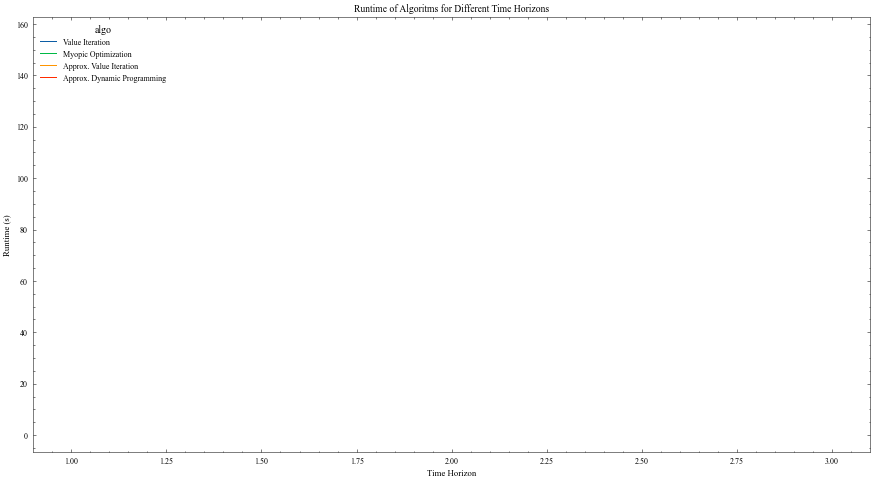

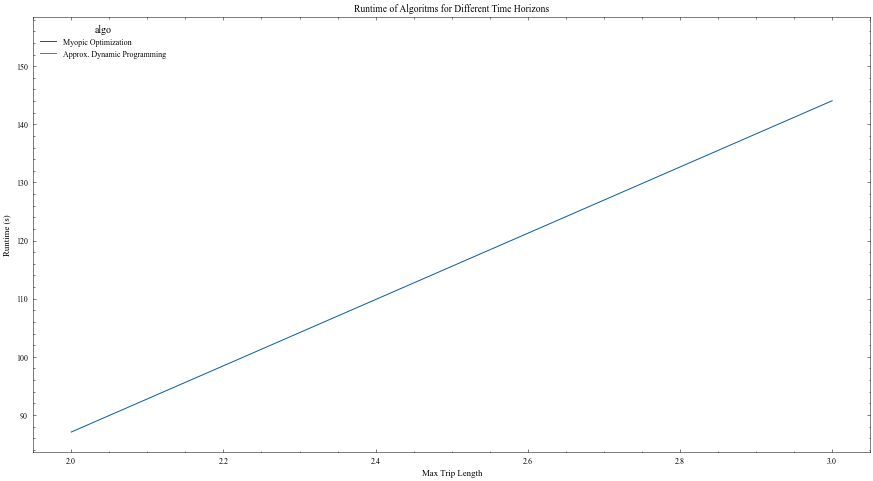

In [16]:
# 3. [ALL] Runtime comparison
plt_rt = pd.DataFrame()

for algo in runs:
    tmp = pd.read_pickle("/usr/app/output/xlsx/%s/rt.pkl" % algo[1]) 
    tmp["algo"] = algo[0]
    plt_rt = plt_rt.append(tmp)

plt_rt_t = plt_rt[(plt_rt.trip_max == param["trip_max"])].copy()
plt_rt_trip_max = plt_rt[(plt_rt["T"] == param["T"])].copy()

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_rt_t, x="T", y="time", hue="algo", legend = True)
plttr.formatPlot(g, "Time Horizon" , "Runtime (s)","Runtime of Algoritms for Different Time Horizons")
plts = [("rt_t", plt.gcf())]

print(plt_rt_trip_max)
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_rt_trip_max, x="trip_max", y="time", hue="algo", legend = True)
plttr.formatPlot(g, "Max Trip Length" , "Runtime (s)","Runtime of Algoritms for Different Time Horizons")
plts = [("rt_trip_nax", plt.gcf())]

2


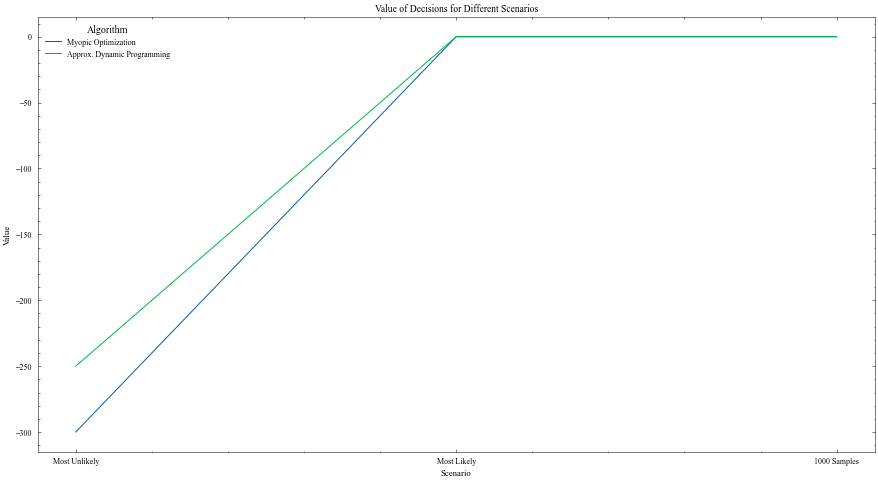

In [28]:
# 4.[~VI] Value according to algorithm and scenario
plt_value = pd.read_pickle("/usr/app/output/xlsx/[%s-%s]-value_comp.pkl" % (param["T"], param["trip_max"]))

fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(ax=ax, data=plt_value, x="Scenario", y="Value", hue="Algorithm", markers=["o" for x in plt_value["Algorithm"].unique()], legend = False)
plttr.formatPlot(g, "Scenario" , "Value","Value of Decisions for Different Scenarios",np.arange(0, 3, 1), None, "Algorithm", ['Myopic Optimization', 'Approx. Dynamic Programming'], "upper left")
g.set_xticklabels(["Most Unlikely", "Most Likely", "1000 Samples"])
plts = [("value_comp", plt.gcf())]

In [ ]:
# 5.[~VI] Decision with price and trip demand

In [ ]:
# Export plots
print(plts)
plttr.save(plts)